#PREDICCIÓN DE CHURN DE CLIENTES

### Inicialización y configuración

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"




In [ ]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.functions import vector_to_array



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [ ]:
spark = SparkSession.builder \
    .appName("Churn Prediction Consulting") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print(f"Spark Version: {spark.version}")
print(f"Master: {spark.sparkContext.master}")
print(f"App Name: {spark.sparkContext.appName}")


Spark Version: 3.4.1
Master: local[*]
App Name: Churn Prediction Consulting


### Carga de Datos

In [ ]:
df_spark = spark.read.csv('abandono_clientes.csv', header=True, inferSchema=True)
df_nuevos_spark = spark.read.csv('clientes_nuevos.csv', header=True, inferSchema=True)

df_spark.cache()
df_nuevos_spark.cache()

print(f"\n Datos cargados exitosamente:")
print(f"   • Registros históricos: {df_spark.count():,}")
print(f"   • Clientes nuevos: {df_nuevos_spark.count():,}")
print(f"   • Columnas: {len(df_spark.columns)}")

print("\n Esquema del Dataset:")
df_spark.printSchema()

print("\n Primeras 5 filas:")
df_spark.show(5, truncate=False)
print("\n Estadísticas Descriptivas:")
df_spark.describe().show()


 Datos cargados exitosamente:
   • Registros históricos: 900
   • Clientes nuevos: 6
   • Columnas: 10

 Esquema del Dataset:
root
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Onboard_date: timestamp (nullable = true)
 |-- Location: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- Churn: integer (nullable = true)


 Primeras 5 filas:
+----------------+----+--------------+---------------+-----+---------+-------------------+--------------------------------------------------+---------------------------+-----+
|Names           |Age |Total_Purchase|Account_Manager|Years|Num_Sites|Onboard_date       |Location                                          |Company                    |Churn|
+----------------+----+--------------+---------------+-----+---------+-----------------

### Valores nulos por columna y duplicados

In [ ]:
print("\n Valores nulos por columna:")
null_counts = df_spark.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in df_spark.columns
]).toPandas()

null_summary = pd.DataFrame({
    'Columna': null_counts.columns,
    'Nulos': null_counts.iloc[0].values,
    'Porcentaje': (null_counts.iloc[0].values / df_spark.count() * 100).round(2)
})

if null_summary['Nulos'].sum() > 0:
    print(null_summary[null_summary['Nulos'] > 0].to_string(index=False))
else:
    print(" No hay valores nulos")

duplicados = df_spark.count() - df_spark.dropDuplicates().count()
print(f"\n Registros duplicados: {duplicados}")


 Valores nulos por columna:
 No hay valores nulos

 Registros duplicados: 0


### Variable Objetivo "CHURN"

In [ ]:
churn_dist = df_spark.groupBy('Churn').count().orderBy('Churn')
churn_pandas = churn_dist.toPandas()
total = df_spark.count()

print("\n Distribución de Churn:")
for row in churn_pandas.itertuples():
    pct = (row.count / total) * 100
    label = "No Churn" if row.Churn == 0 else "Churn"
    print(f"   • {label} ({row.Churn}): {row.count:,} clientes ({pct:.2f}%)")

ratio = churn_pandas.iloc[0]['count'] / churn_pandas.iloc[1]['count']
print(f"   • Ratio No Churn:Churn = 1:{ratio:.2f}")



 Distribución de Churn:
   • No Churn (0): 750 clientes (83.33%)
   • Churn (1): 150 clientes (16.67%)
   • Ratio No Churn:Churn = 1:5.00


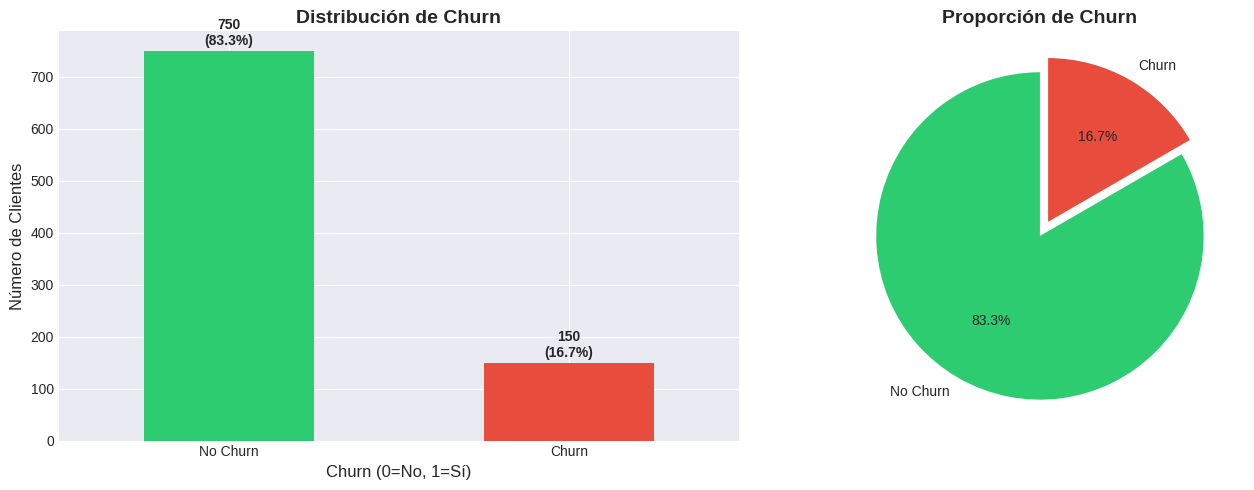

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

churn_pandas.plot(x='Churn', y='count', kind='bar', ax=axes[0],
                  color=['#2ecc71', '#e74c3c'], legend=False)
axes[0].set_title('Distribución de Churn', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn (0=No, 1=Sí)', fontsize=12)
axes[0].set_ylabel('Número de Clientes', fontsize=12)
axes[0].set_xticklabels(['No Churn', 'Churn'], rotation=0)
for i, row in churn_pandas.iterrows():
    pct = (row['count'] / total) * 100
    axes[0].text(i, row['count'] + 5, f"{row['count']}\n({pct:.1f}%)",
                ha='center', va='bottom', fontweight='bold')

axes[1].pie(churn_pandas['count'], labels=['No Churn', 'Churn'],
           autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'],
           startangle=90, explode=(0, 0.1))
axes[1].set_title('Proporción de Churn', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Ingeniería de Características



*  Conversión de Fechas
*  Características Temporales
*  Características Derivadas
*  Información Geográfica


In [ ]:
df_spark = df_spark.withColumn('Onboard_date', F.to_timestamp('Onboard_date'))

df_spark = df_spark \
    .withColumn('Onboard_Year', F.year('Onboard_date')) \
    .withColumn('Onboard_Month', F.month('Onboard_date')) \
    .withColumn('Onboard_Quarter', F.quarter('Onboard_date')) \
    .withColumn('Onboard_DayOfWeek', F.dayofweek('Onboard_date')) \
    .withColumn('Days_Since_Onboard',
                F.datediff(F.current_date(), F.col('Onboard_date')))

df_spark = df_spark \
    .withColumn('Purchase_Per_Year', F.col('Total_Purchase') / F.col('Years')) \
    .withColumn('Purchase_Per_Site', F.col('Total_Purchase') / F.col('Num_Sites')) \
    .withColumn('Sites_Per_Year', F.col('Num_Sites') / F.col('Years')) \
    .withColumn('Years_Squared', F.pow(F.col('Years'), 2)) \
    .withColumn('Age_Purchase_Interaction', F.col('Age') * F.col('Total_Purchase'))

df_spark = df_spark.withColumn('Age_Group',
    F.when(F.col('Age') < 30, '<30')
    .when((F.col('Age') >= 30) & (F.col('Age') < 40), '30-40')
    .when((F.col('Age') >= 40) & (F.col('Age') < 50), '40-50')
    .otherwise('50+')
)

df_spark = df_spark.withColumn('State',
    F.regexp_extract('Location', r',\s+([A-Z]{2})\s+\d', 1)
)

window_spec = Window.orderBy('Onboard_date')
df_spark = df_spark.withColumn('Customer_Sequence', F.row_number().over(window_spec))
df_spark = df_spark.withColumn('Running_Avg_Purchase',
    F.avg('Total_Purchase').over(window_spec.rowsBetween(Window.unboundedPreceding, 0))
)

print("\n Características creadas:")
print("Temporales: Onboard_Year, Month, Quarter, DayOfWeek, Days_Since_Onboard")
print("Derivadas: Purchase_Per_Year, Purchase_Per_Site, Sites_Per_Year")
print("Interacciones: Years_Squared, Age_Purchase_Interaction")
print("Categóricas: Age_Group, State")
print("Tendencias: Customer_Sequence, Running_Avg_Purchase")

print(f"\n Nuevas dimensiones: {df_spark.count():,} filas x {len(df_spark.columns)} columnas")



 Características creadas:
Temporales: Onboard_Year, Month, Quarter, DayOfWeek, Days_Since_Onboard
Derivadas: Purchase_Per_Year, Purchase_Per_Site, Sites_Per_Year
Interacciones: Years_Squared, Age_Purchase_Interaction
Categóricas: Age_Group, State
Tendencias: Customer_Sequence, Running_Avg_Purchase

 Nuevas dimensiones: 900 filas x 24 columnas


In [ ]:
df_spark.select('Age', 'Total_Purchase', 'Years', 'Purchase_Per_Year',
                'Age_Group', 'State', 'Churn').show(10)


+----+--------------+-----+------------------+---------+-----+-----+
| Age|Total_Purchase|Years| Purchase_Per_Year|Age_Group|State|Churn|
+----+--------------+-----+------------------+---------+-----+-----+
|25.0|       9672.03| 5.49|1761.7540983606557|      <30|     |    0|
|39.0|       6168.66| 4.71|1309.6942675159235|    30-40|     |    0|
|45.0|       9722.92| 3.35|2902.3641791044774|    40-50|   MA|    0|
|44.0|      10309.15| 6.35| 1623.488188976378|    40-50|   MP|    0|
|51.0|       8100.43| 4.92| 1646.428861788618|      50+|   MI|    1|
|43.0|      10598.35| 6.72|1577.1354166666667|    40-50|     |    0|
|34.0|      12813.91| 2.41|5316.9751037344395|    30-40|   WA|    0|
|48.0|      13189.35| 3.25|4058.2615384615387|    40-50|   PA|    0|
|38.0|       9347.47| 8.47|1103.5974025974024|    30-40|   NM|    0|
|43.0|      10938.11| 3.21|3407.5109034267916|    40-50|   IA|    0|
+----+--------------+-----+------------------+---------+-----+-----+
only showing top 10 rows



### Análisis Univariado de Variables Númericas

In [ ]:
numeric_cols = ['Age', 'Total_Purchase', 'Years', 'Num_Sites',
                'Purchase_Per_Year', 'Purchase_Per_Site', 'Sites_Per_Year']

for col in numeric_cols:
    stats_df = df_spark.select(
        F.mean(col).alias('mean'),
        F.stddev(col).alias('std'),
        F.min(col).alias('min'),
        F.expr(f'percentile({col}, 0.25)').alias('q25'),
        F.expr(f'percentile({col}, 0.50)').alias('median'),
        F.expr(f'percentile({col}, 0.75)').alias('q75'),
        F.max(col).alias('max'),
        F.skewness(col).alias('skewness'),
        F.kurtosis(col).alias('kurtosis')
    ).toPandas()

    print(f"\n {col}:")
    for stat_name in stats_df.columns:
        print(f"   • {stat_name.capitalize()}: {stats_df[stat_name].iloc[0]:.2f}")



 Age:
   • Mean: 41.82
   • Std: 6.13
   • Min: 22.00
   • Q25: 38.00
   • Median: 42.00
   • Q75: 46.00
   • Max: 65.00
   • Skewness: 0.09
   • Kurtosis: -0.02

 Total_Purchase:
   • Mean: 10062.82
   • Std: 2408.64
   • Min: 100.00
   • Q25: 8497.12
   • Median: 10045.87
   • Q75: 11760.10
   • Max: 18026.01
   • Skewness: -0.10
   • Kurtosis: -0.00

 Years:
   • Mean: 5.27
   • Std: 1.27
   • Min: 1.00
   • Q25: 4.45
   • Median: 5.21
   • Q75: 6.11
   • Max: 9.15
   • Skewness: 0.01
   • Kurtosis: 0.18

 Num_Sites:
   • Mean: 8.59
   • Std: 1.76
   • Min: 3.00
   • Q25: 7.00
   • Median: 8.00
   • Q75: 10.00
   • Max: 14.00
   • Skewness: 0.19
   • Kurtosis: 0.12

 Purchase_Per_Year:
   • Mean: 2055.98
   • Std: 896.97
   • Min: 18.98
   • Q25: 1486.32
   • Median: 1905.65
   • Q75: 2409.39
   • Max: 9472.72
   • Skewness: 2.77
   • Kurtosis: 14.77

 Purchase_Per_Site:
   • Mean: 1227.98
   • Std: 424.40
   • Min: 20.00
   • Q25: 939.99
   • Median: 1174.76
   • Q75: 1455.35
   •

### CHURN  vs Variables

In [ ]:
print("\n Comparación de medias por Churn:")

comparison_results = []
for col in numeric_cols:
    stats_by_churn = df_spark.groupBy('Churn').agg(
        F.mean(col).alias('mean'),
        F.stddev(col).alias('std'),
        F.count(col).alias('count')
    ).orderBy('Churn').toPandas()

    comparison_results.append({
        'Variable': col,
        'No_Churn_Mean': stats_by_churn.iloc[0]['mean'],
        'Churn_Mean': stats_by_churn.iloc[1]['mean'],
        'Difference': stats_by_churn.iloc[1]['mean'] - stats_by_churn.iloc[0]['mean'],
        'Pct_Difference': ((stats_by_churn.iloc[1]['mean'] / stats_by_churn.iloc[0]['mean']) - 1) * 100
    })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df.to_string(index=False))



 Comparación de medias por Churn:
         Variable  No_Churn_Mean   Churn_Mean  Difference  Pct_Difference
              Age      41.581333    42.993333    1.412000        3.395755
   Total_Purchase   10036.952853 10192.179933  155.227080        1.546556
            Years       5.151067     5.883600    0.732533       14.221003
        Num_Sites       8.173333    10.660000    2.486667       30.424144
Purchase_Per_Year    2104.837012  1811.692886 -293.144127      -13.927165
Purchase_Per_Site    1278.397839   975.874744 -302.523094      -23.664237
   Sites_Per_Year       1.717603     1.908998    0.191395       11.143118


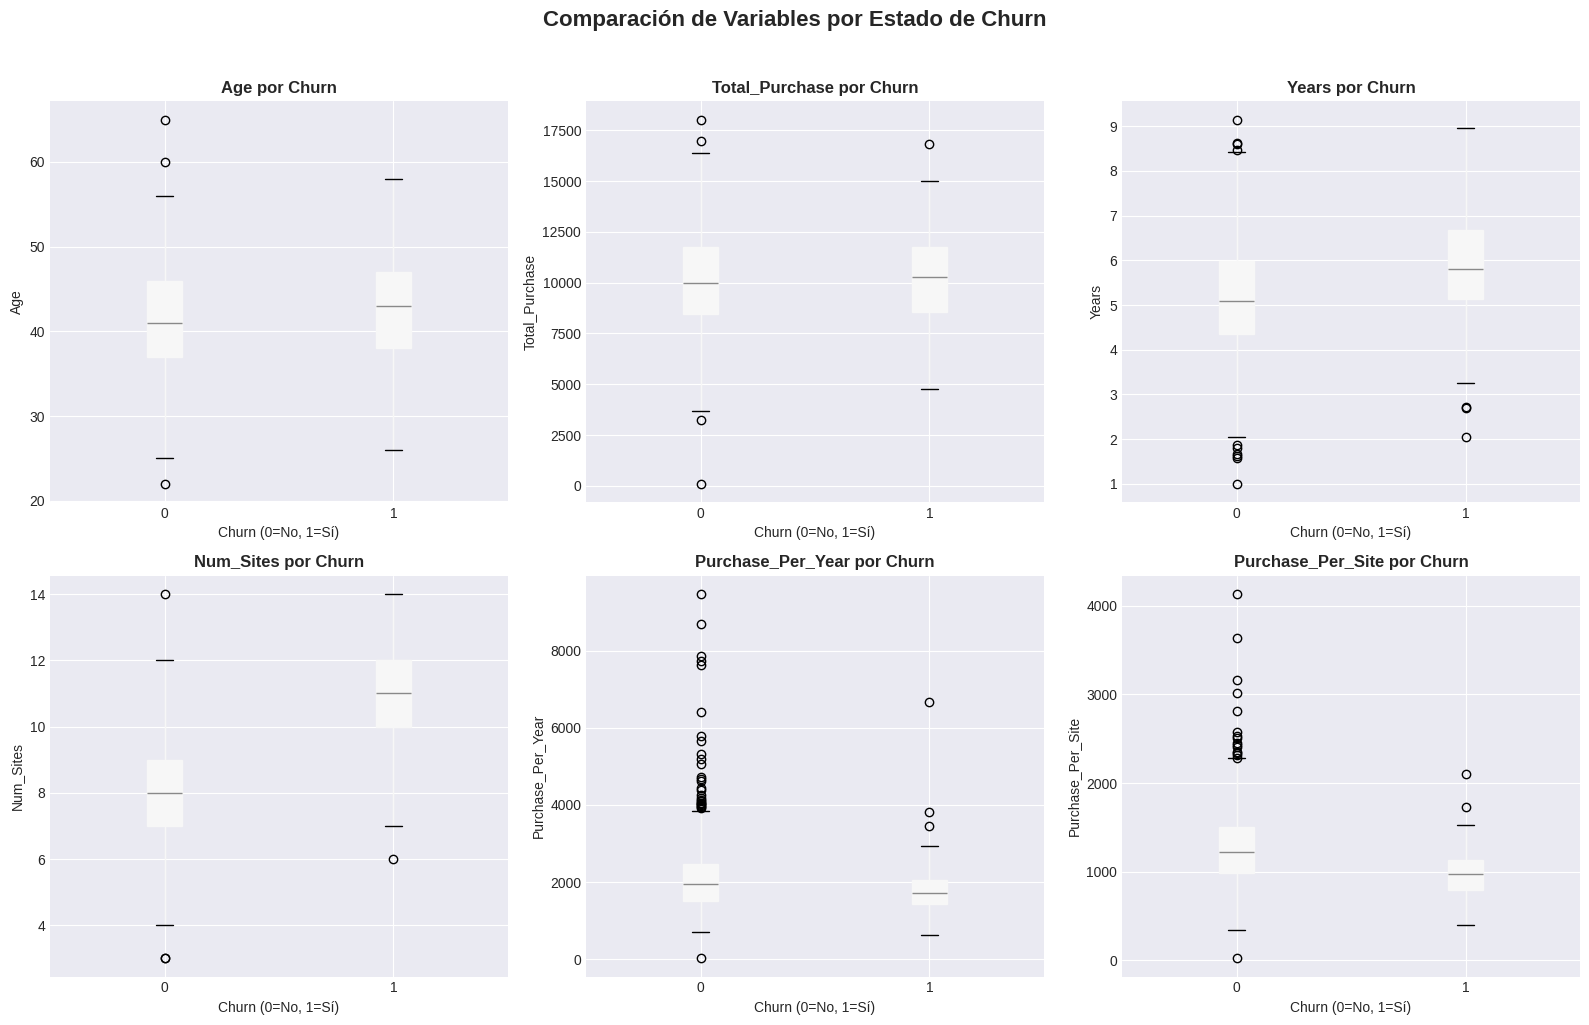

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols[:6]):
    plot_data = df_spark.select(col, 'Churn').toPandas()

    plot_data.boxplot(column=col, by='Churn', ax=axes[idx], patch_artist=True)
    axes[idx].set_title(f'{col} por Churn', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn (0=No, 1=Sí)')
    axes[idx].set_ylabel(col)
    axes[idx].get_figure().suptitle('')

plt.suptitle('Comparación de Variables por Estado de Churn',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Correlaciones y categóricas

In [ ]:
numeric_cols_corr = ['Age', 'Total_Purchase', 'Account_Manager', 'Years',
                     'Num_Sites', 'Purchase_Per_Year', 'Purchase_Per_Site',
                     'Sites_Per_Year', 'Days_Since_Onboard', 'Churn']

df_corr = df_spark.select(*numeric_cols_corr).na.drop()

assembler_corr = VectorAssembler(inputCols=numeric_cols_corr, outputCol="features")
df_vector = assembler_corr.transform(df_corr)

correlation_matrix = Correlation.corr(df_vector, "features", "pearson").head()[0]
correlation_array = correlation_matrix.toArray()

correlation_df = pd.DataFrame(
    correlation_array,
    columns=numeric_cols_corr,
    index=numeric_cols_corr
)

print("\n Matriz de Correlación:")
print(correlation_df.round(3))



 Matriz de Correlación:
                      Age  Total_Purchase  Account_Manager  Years  Num_Sites  \
Age                 1.000          -0.037           -0.015  0.006     -0.006   
Total_Purchase     -0.037           1.000            0.016 -0.006     -0.003   
Account_Manager    -0.015           0.016            1.000  0.023      0.033   
Years               0.006          -0.006            0.023  1.000      0.052   
Num_Sites          -0.006          -0.003            0.033  0.052      1.000   
Purchase_Per_Year  -0.029           0.588            0.013 -0.682     -0.017   
Purchase_Per_Site  -0.016           0.703           -0.010 -0.039     -0.645   
Sites_Per_Year     -0.016           0.015            0.014 -0.711      0.487   
Days_Since_Onboard -0.003           0.021           -0.022  0.045      0.032   
Churn               0.086           0.024            0.071  0.214      0.525   

                    Purchase_Per_Year  Purchase_Per_Site  Sites_Per_Year  \
Age               

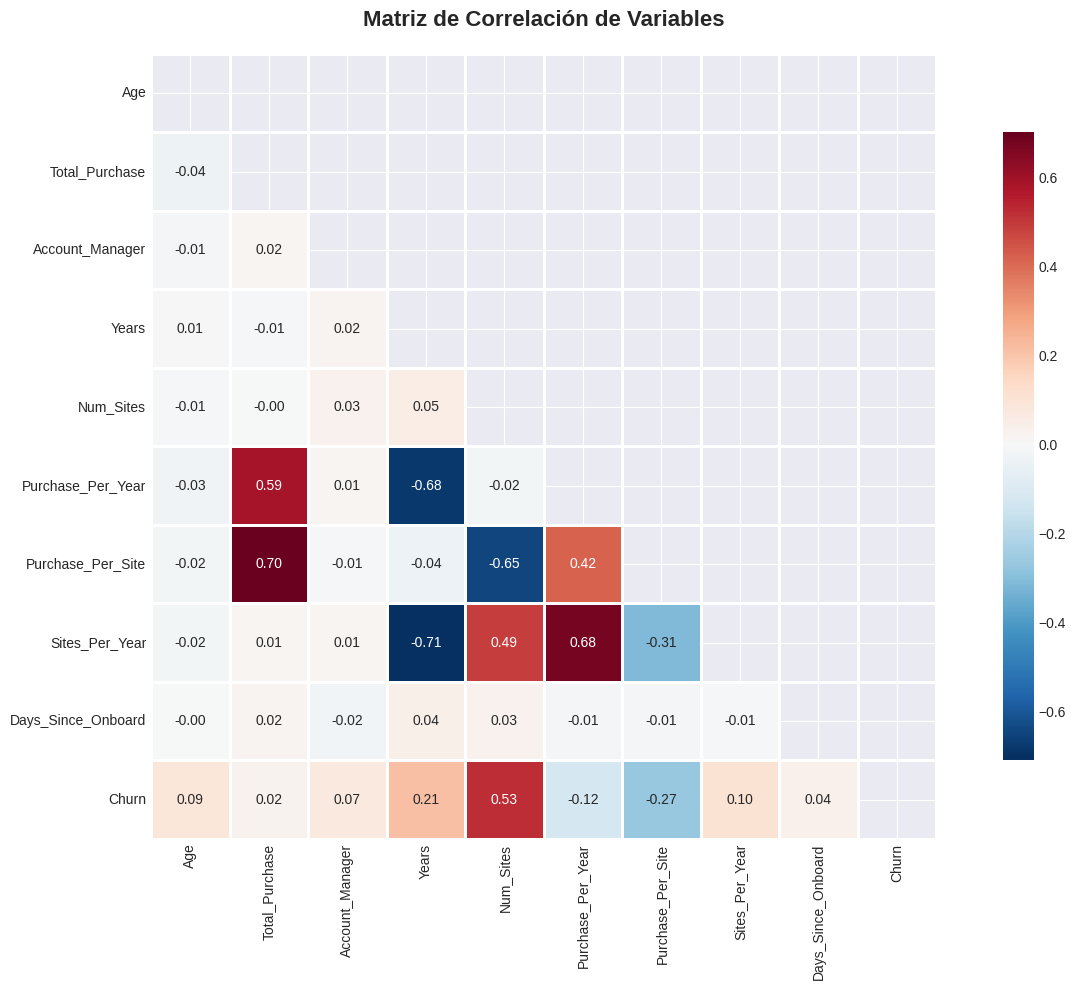

In [ ]:
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_df, dtype=bool))
sns.heatmap(correlation_df, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, mask=mask,
            cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### Correlación con Churn

In [ ]:
churn_corr = correlation_df['Churn'].sort_values(ascending=False)
print("\n Correlación con Churn (ordenado):")
print(churn_corr)





 Correlación con Churn (ordenado):
Churn                 1.000000
Num_Sites             0.525398
Years                 0.214329
Sites_Per_Year        0.101297
Age                   0.085926
Account_Manager       0.070611
Days_Since_Onboard    0.038141
Total_Purchase        0.024031
Purchase_Per_Year    -0.121864
Purchase_Per_Site    -0.265803
Name: Churn, dtype: float64


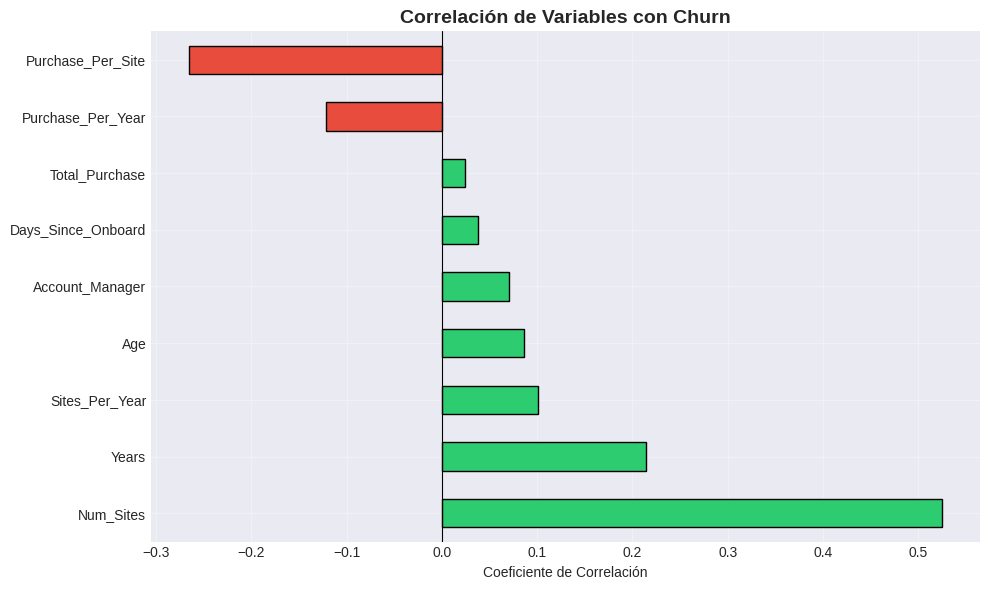

In [ ]:
plt.figure(figsize=(10, 6))
churn_corr_plot = churn_corr.drop('Churn')
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in churn_corr_plot]
churn_corr_plot.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Correlación de Variables con Churn', fontsize=14, fontweight='bold')
plt.xlabel('Coeficiente de Correlación')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Variables Categóricas

### Account Manager vs Churn

In [ ]:
am_churn = df_spark.groupBy('Account_Manager', 'Churn').count()
am_pivot = am_churn.groupBy('Account_Manager').pivot('Churn').sum('count').fillna(0)
am_pandas = am_pivot.toPandas()

In [ ]:
am_pandas.columns = [str(c) for c in am_pandas.columns]

am_pandas['Total'] = am_pandas['0'] + am_pandas['1']
am_pandas['Churn_Rate'] = (am_pandas['1'] / am_pandas['Total']) * 100


print(am_pandas.to_string(index=False))



 Account_Manager   0  1  Total  Churn_Rate
               1 349 84    433   19.399538
               0 401 66    467   14.132762


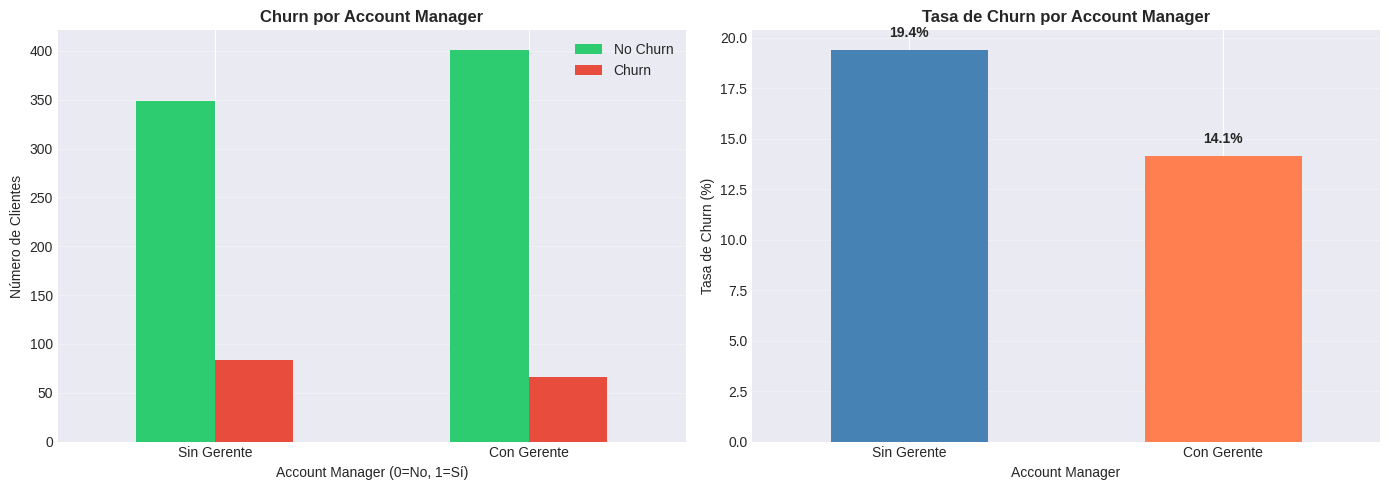

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

am_pandas.plot(x='Account_Manager', y=['0', '1'], kind='bar', ax=axes[0],
              color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Churn por Account Manager', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Account Manager (0=No, 1=Sí)')
axes[0].set_ylabel('Número de Clientes')
axes[0].set_xticklabels(['Sin Gerente', 'Con Gerente'], rotation=0)
axes[0].legend(['No Churn', 'Churn'])
axes[0].grid(True, alpha=0.3, axis='y')

am_pandas.plot(x='Account_Manager', y='Churn_Rate', kind='bar', ax=axes[1],
              color=['steelblue', 'coral'], legend=False)
axes[1].set_title('Tasa de Churn por Account Manager', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Account Manager')
axes[1].set_ylabel('Tasa de Churn (%)')
axes[1].set_xticklabels(['Sin Gerente', 'Con Gerente'], rotation=0)
for i, v in enumerate(am_pandas['Churn_Rate']):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Age Group vs Churn

In [ ]:
age_churn = df_spark.groupBy('Age_Group', 'Churn').count()
age_pivot = age_churn.groupBy('Age_Group').pivot('Churn').sum('count').fillna(0)
age_pandas = age_pivot.toPandas()
age_pandas['Total'] = age_pandas['0'] + age_pandas['1']
age_pandas['Churn_Rate'] = (age_pandas['1'] / age_pandas['Total']) * 100

print(age_pandas.to_string(index=False))

Age_Group   0  1  Total  Churn_Rate
    40-50 404 83    487   17.043121
      50+  71 24     95   25.263158
    30-40 258 41    299   13.712375
      <30  17  2     19   10.526316


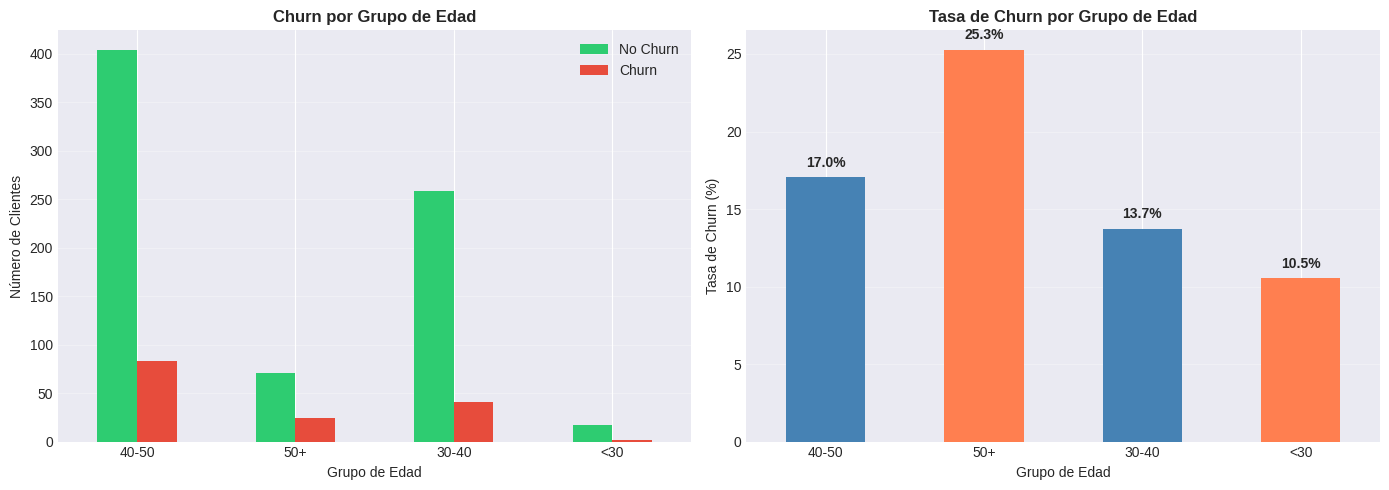

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

age_pandas.plot(x='Age_Group', y=['0', '1'], kind='bar', ax=axes[0],
              color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Churn por Grupo de Edad', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Grupo de Edad')
axes[0].set_ylabel('Número de Clientes')
axes[0].set_xticklabels(age_pandas['Age_Group'], rotation=0)
axes[0].legend(['No Churn', 'Churn'])
axes[0].grid(True, alpha=0.3, axis='y')

age_pandas.plot(x='Age_Group', y='Churn_Rate', kind='bar', ax=axes[1],
              color=['steelblue', 'coral'], legend=False)
axes[1].set_title('Tasa de Churn por Grupo de Edad', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Grupo de Edad')
axes[1].set_ylabel('Tasa de Churn (%)')
axes[1].set_xticklabels(age_pandas['Age_Group'], rotation=0)
for i, v in enumerate(age_pandas['Churn_Rate']):
    axes[1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Estado Geográfico

In [ ]:
state_stats = df_spark.groupBy('State').agg(
    F.mean('Churn').alias('Churn_Rate'),
    F.count('*').alias('Total_Clients')
).filter(F.col('State') != '') \
 .orderBy(F.desc('Churn_Rate')) \
 .limit(10) \
 .toPandas()

state_stats['Churn_Rate'] = state_stats['Churn_Rate'] * 100
print(state_stats.to_string(index=False))


State  Churn_Rate  Total_Clients
   MH   43.750000             16
   WY   42.857143              7
   NJ   38.461538             13
   DE   36.363636             11
   AS   36.363636             11
   LA   29.411765             17
   RI   28.571429             14
   CO   27.272727             11
   MI   26.666667             15
   NE   25.000000             12


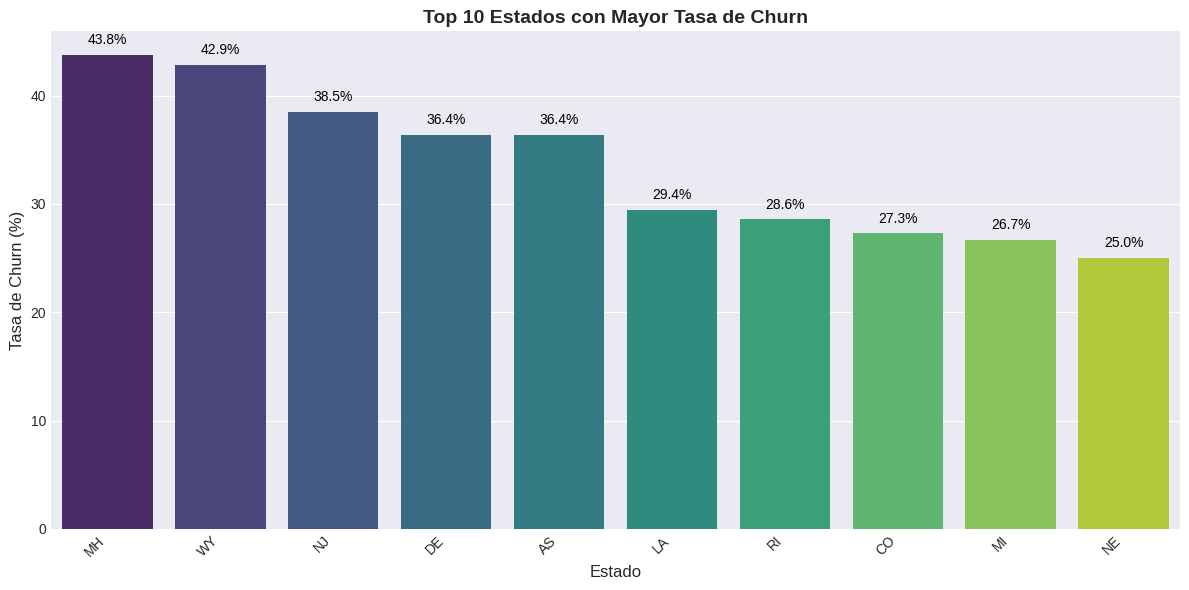

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='State', y='Churn_Rate', data=state_stats, palette='viridis')
plt.title('Top 10 Estados con Mayor Tasa de Churn', fontsize=14, fontweight='bold')
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Tasa de Churn (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
for index, row in state_stats.iterrows():
    plt.text(index, row['Churn_Rate'] + 1, f"{row['Churn_Rate']:.1f}%", color='black', ha="center")
plt.tight_layout()
plt.show()

### Detección de Outliers

In [ ]:
for col in numeric_cols:
    quantiles = df_spark.approxQuantile(col, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = df_spark.filter(
        (F.col(col) < lower_bound) | (F.col(col) > upper_bound)
    ).count()

    pct = (outliers_count / df_spark.count()) * 100

    print(f"\n{col}:")
    print(f"   • Q1: {Q1:.2f}")
    print(f"   • Q3: {Q3:.2f}")
    print(f"   • IQR: {IQR:.2f}")
    print(f"   • Límite inferior: {lower_bound:.2f}")
    print(f"   • Límite superior: {upper_bound:.2f}")
    print(f"   • Outliers detectados: {outliers_count} ({pct:.2f}%)")


Age:
   • Q1: 37.00
   • Q3: 46.00
   • IQR: 9.00
   • Límite inferior: 23.50
   • Límite superior: 59.50
   • Outliers detectados: 3 (0.33%)

Total_Purchase:
   • Q1: 8427.12
   • Q3: 11680.91
   • IQR: 3253.79
   • Límite inferior: 3546.44
   • Límite superior: 16561.59
   • Outliers detectados: 5 (0.56%)

Years:
   • Q1: 4.43
   • Q3: 6.05
   • IQR: 1.62
   • Límite inferior: 2.00
   • Límite superior: 8.48
   • Outliers detectados: 13 (1.44%)

Num_Sites:
   • Q1: 7.00
   • Q3: 10.00
   • IQR: 3.00
   • Límite inferior: 2.50
   • Límite superior: 14.50
   • Outliers detectados: 0 (0.00%)

Purchase_Per_Year:
   • Q1: 1469.21
   • Q3: 2388.42
   • IQR: 919.21
   • Límite inferior: 90.40
   • Límite superior: 3767.23
   • Outliers detectados: 34 (3.78%)

Purchase_Per_Site:
   • Q1: 931.56
   • Q3: 1439.20
   • IQR: 507.64
   • Límite inferior: 170.10
   • Límite superior: 2200.66
   • Outliers detectados: 22 (2.44%)

Sites_Per_Year:
   • Q1: 1.32
   • Q3: 1.97
   • IQR: 0.65
   • Lími

### Modelado

### Selección de Features

In [ ]:
feature_cols = [
    'Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites',
    'Purchase_Per_Year', 'Purchase_Per_Site', 'Sites_Per_Year',
    'Days_Since_Onboard', 'Onboard_Year', 'Onboard_Month', 'Onboard_Quarter',
    'Years_Squared', 'Age_Purchase_Interaction'
]

### Limpieza de valores Infinitos

In [ ]:
df_clean = df_spark.select(*feature_cols, 'Churn').na.drop()

for col in feature_cols:
    df_clean = df_clean.filter(
        ~F.isnan(F.col(col)) &
        ~(F.col(col) == float('inf')) &
        ~(F.col(col) == float('-inf'))
    )


print(f"\n Features seleccionados: {len(feature_cols)}")
print(f" Registros después de limpieza: {df_clean.count():,}")


 Features seleccionados: 14
 Registros después de limpieza: 900


In [ ]:
churn_dist_clean = df_clean.groupBy('Churn').count().toPandas()
print(f"\n Distribución de Churn en datos limpios:")
for _, row in churn_dist_clean.iterrows():
    pct = (row['count'] / df_clean.count()) * 100
    label = "No Churn" if row['Churn'] == 0 else "Churn"
    print(f"   • {label}: {row['count']:,} ({pct:.2f}%)")


 Distribución de Churn en datos limpios:
   • Churn: 150 (16.67%)
   • No Churn: 750 (83.33%)


### División Train/Test (70-30) con estratificación


In [ ]:
class_fractions = df_clean.groupBy('Churn').count().collect()
total_count = df_clean.count()

train_fraction = 0.7
test_fraction = 0.3

df_churn_0 = df_clean.filter(F.col('Churn') == 0)
df_churn_1 = df_clean.filter(F.col('Churn') == 1)

train_0, test_0 = df_churn_0.randomSplit([train_fraction, test_fraction], seed=42)
train_1, test_1 = df_churn_1.randomSplit([train_fraction, test_fraction], seed=42)

df_train = train_0.union(train_1)
df_test = test_0.union(test_1)

df_train.cache()
df_test.cache()

print(f"\n División de datos:")
print(f"   • Train set: {df_train.count():,} registros ({df_train.count()/df_clean.count()*100:.1f}%)")
print(f"   • Test set: {df_test.count():,} registros ({df_test.count()/df_clean.count()*100:.1f}%)")

train_churn = df_train.groupBy('Churn').count().toPandas()
test_churn = df_test.groupBy('Churn').count().toPandas()

print(f"   • Train Churn distribution:")
for _, row in train_churn.iterrows():
    print(f"     - Clase {row['Churn']}: {row['count']} ({row['count']/df_train.count()*100:.1f}%)")

print(f"   • Test Churn distribution:")
for _, row in test_churn.iterrows():
    print(f"     - Clase {row['Churn']}: {row['count']} ({row['count']/df_test.count()*100:.1f}%)")



 División de datos:
   • Train set: 659 registros (73.2%)
   • Test set: 241 registros (26.8%)
   • Train Churn distribution:
     - Clase 0: 555 (84.2%)
     - Clase 1: 104 (15.8%)
   • Test Churn distribution:
     - Clase 0: 195 (80.9%)
     - Clase 1: 46 (19.1%)


### Pipeline de Transformación

In [ ]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_raw",
    handleInvalid="skip"
)

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

from pyspark.ml import Pipeline

transform_pipeline = Pipeline(stages=[assembler, scaler])

pipeline_model = transform_pipeline.fit(df_train)

df_train_transformed = pipeline_model.transform(df_train)
df_test_transformed = pipeline_model.transform(df_test)

print("\n Pipeline de transformación creado:")
print("   • VectorAssembler: Combina features en vector")
print("   • StandardScaler: Normaliza features (media=0, std=1)")
df_train_transformed.select('Churn', 'features').show(5, truncate=False)

df_train_transformed.cache()
df_test_transformed.cache()

print("\n Datos preparados y cacheados para modelado")



 Pipeline de transformación creado:
   • VectorAssembler: Combina features en vector
   • StandardScaler: Normaliza features (media=0, std=1)
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Churn|features                                                                                                                                                                                                                                                                                   |
+-----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Manejo de desbalance de Clases

In [ ]:
churn_counts = df_train_transformed.groupBy('Churn').count().collect()
total = df_train_transformed.count()

class_weights = {}
for row in churn_counts:
    class_weights[row['Churn']] = total / (len(churn_counts) * row['count'])

print(f"\n Class Weights calculados:")
for churn_class, weight in class_weights.items():
    print(f"   • Clase {churn_class}: {weight:.4f}")

df_train_weighted = df_train_transformed.withColumn(
    'classWeight',
    F.when(F.col('Churn') == 0, class_weights[0])
    .otherwise(class_weights[1])
)


 Class Weights calculados:
   • Clase 0: 0.5937
   • Clase 1: 3.1683


In [ ]:
minority_class = df_train_transformed.filter(F.col('Churn') == 1)
majority_class = df_train_transformed.filter(F.col('Churn') == 0)

minority_count = minority_class.count()
majority_count = majority_class.count()

sample_ratio = majority_count / minority_count

minority_oversampled = minority_class.sample(withReplacement=True,
                                             fraction=sample_ratio,
                                             seed=42)

df_train_balanced = majority_class.union(minority_oversampled)

print(f"\n Antes del balanceo:")
print(f"   • Clase 0: {majority_count:,}")
print(f"   • Clase 1: {minority_count:,}")
print(f"   • Ratio: 1:{majority_count/minority_count:.2f}")

print(f"\n Después del balanceo (oversampling):")
balanced_counts = df_train_balanced.groupBy('Churn').count().toPandas()
for _, row in balanced_counts.iterrows():
    print(f"   • Clase {row['Churn']}: {row['count']:,}")




 Antes del balanceo:
   • Clase 0: 555
   • Clase 1: 104
   • Ratio: 1:5.34

 Después del balanceo (oversampling):
   • Clase 0: 555
   • Clase 1: 544


### Entrenamiento de modelos

### Definir evaluadores

In [ ]:
evaluator_auc = BinaryClassificationEvaluator(
    labelCol='Churn',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol='Churn',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderPR'
)

evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='Churn',
    predictionCol='prediction',
    metricName='accuracy'
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='Churn',
    predictionCol='prediction',
    metricName='f1'
)


### Función de Evaluación

In [ ]:
def evaluate_model(predictions, model_name):

    auc = evaluator_auc.evaluate(predictions)
    pr_auc = evaluator_pr.evaluate(predictions)
    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    predictions_rdd = predictions.select(['Churn', 'prediction']) \
        .rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictions_rdd)

    confusion_matrix = metrics.confusionMatrix().toArray()

    precision_0 = metrics.precision(0.0)
    precision_1 = metrics.precision(1.0)
    recall_0 = metrics.recall(0.0)
    recall_1 = metrics.recall(1.0)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision_Class_0': precision_0,
        'Precision_Class_1': precision_1,
        'Recall_Class_0': recall_0,
        'Recall_Class_1': recall_1,
        'F1-Score': f1,
        'ROC-AUC': auc,
        'PR-AUC': pr_auc,
        'Confusion_Matrix': confusion_matrix
    }

### Regresión Logistica


Modelos a Entrenar:
1. Regresión Logística Estándar (Ridge L2)
2. Regresión Logística con Lasso (L1)
3. Regresión Logística con Elastic Net (L1 + L2)

In [ ]:
evaluator_auc = BinaryClassificationEvaluator(
    labelCol='Churn',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderROC'
)

evaluator_pr = BinaryClassificationEvaluator(
    labelCol='Churn',
    rawPredictionCol='rawPrediction',
    metricName='areaUnderPR'
)

evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol='Churn',
    predictionCol='prediction',
    metricName='accuracy'
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol='Churn',
    predictionCol='prediction',
    metricName='f1'
)


### Función de evaluación

In [ ]:
def evaluate_logistic_model(predictions, model_name):
    """Evalúa un modelo de regresión logística con métricas detalladas"""

    auc = evaluator_auc.evaluate(predictions)
    pr_auc = evaluator_pr.evaluate(predictions)
    accuracy = evaluator_accuracy.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)

    predictions_rdd = predictions.select(['Churn', 'prediction']) \
        .rdd.map(lambda x: (float(x[0]), float(x[1])))
    metrics = MulticlassMetrics(predictions_rdd)
    confusion_matrix = metrics.confusionMatrix().toArray()

    precision_0 = metrics.precision(0.0)
    precision_1 = metrics.precision(1.0)
    recall_0 = metrics.recall(0.0)
    recall_1 = metrics.recall(1.0)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision_Class_0': precision_0,
        'Precision_Class_1': precision_1,
        'Recall_Class_0': recall_0,
        'Recall_Class_1': recall_1,
        'F1-Score': f1,
        'ROC-AUC': auc,
        'PR-AUC': pr_auc,
        'Confusion_Matrix': confusion_matrix
    }

### REGRESIÓN LOGÍSTICA CON RIDGE (L2)

In [ ]:
lr_ridge = LogisticRegression(
    featuresCol='features',
    labelCol='Churn',
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0,
    family='binomial',
    standardization=False,
    threshold=0.5
)

print("\nEntrenando Ridge Logistic Regression...")
lr_ridge_model = lr_ridge.fit(df_train_balanced)
lr_ridge_predictions = lr_ridge_model.transform(df_test_transformed)
lr_ridge_results = evaluate_logistic_model(lr_ridge_predictions, 'Logistic Regression (Ridge L2)')

print(f"Accuracy: {lr_ridge_results['Accuracy']:.4f}")
print(f"F1-Score: {lr_ridge_results['F1-Score']:.4f}")
print(f"ROC-AUC: {lr_ridge_results['ROC-AUC']:.4f}")
print(f"Coeficientes no-cero: {np.count_nonzero(lr_ridge_model.coefficients.toArray())}/{len(lr_ridge_model.coefficients)}")


Entrenando Ridge Logistic Regression...
Accuracy: 0.8091
F1-Score: 0.8246
ROC-AUC: 0.8800
Coeficientes no-cero: 14/14


### RL con Lasso

In [ ]:
lr_lasso = LogisticRegression(
    featuresCol='features',
    labelCol='Churn',
    maxIter=100,
    regParam=0.01,
    elasticNetParam=1.0,
    family='binomial',
    standardization=False,
    threshold=0.5
)

print("\nEntrenando Lasso Logistic Regression...")
lr_lasso_model = lr_lasso.fit(df_train_balanced)
lr_lasso_predictions = lr_lasso_model.transform(df_test_transformed)
lr_lasso_results = evaluate_logistic_model(lr_lasso_predictions, 'Logistic Regression (Lasso L1)')

print(f"Accuracy: {lr_lasso_results['Accuracy']:.4f}")
print(f"F1-Score: {lr_lasso_results['F1-Score']:.4f}")
print(f"ROC-AUC: {lr_lasso_results['ROC-AUC']:.4f}")
print(f"Coeficientes no-cero: {np.count_nonzero(lr_lasso_model.coefficients.toArray())}/{len(lr_lasso_model.coefficients)}")
print(f"Features eliminados: {len(lr_lasso_model.coefficients) - np.count_nonzero(lr_lasso_model.coefficients.toArray())}")


Entrenando Lasso Logistic Regression...
Accuracy: 0.8050
F1-Score: 0.8211
ROC-AUC: 0.8821
Coeficientes no-cero: 5/14
Features eliminados: 9


### Modelo con Elastic Net

In [ ]:
lr_elastic = LogisticRegression(
    featuresCol='features',
    labelCol='Churn',
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.5,
    family='binomial',
    standardization=False,
    threshold=0.5
)

print("\nEntrenando Elastic Net Logistic Regression...")
lr_elastic_model = lr_elastic.fit(df_train_balanced)
lr_elastic_predictions = lr_elastic_model.transform(df_test_transformed)
lr_elastic_results = evaluate_logistic_model(lr_elastic_predictions, 'Logistic Regression (Elastic Net)')

print(f"Accuracy: {lr_elastic_results['Accuracy']:.4f}")
print(f"F1-Score: {lr_elastic_results['F1-Score']:.4f}")
print(f"ROC-AUC: {lr_elastic_results['ROC-AUC']:.4f}")
print(f"Coeficientes no-cero: {np.count_nonzero(lr_elastic_model.coefficients.toArray())}/{len(lr_elastic_model.coefficients)}")



Entrenando Elastic Net Logistic Regression...
Accuracy: 0.8091
F1-Score: 0.8246
ROC-AUC: 0.8789
Coeficientes no-cero: 10/14


### Comparación

In [ ]:
all_results = [lr_ridge_results, lr_lasso_results, lr_elastic_results]

results_df = pd.DataFrame([
    {
        'Model': r['Model'],
        'Accuracy': r['Accuracy'],
        'Precision': r['Precision_Class_1'],
        'Recall': r['Recall_Class_1'],
        'F1-Score': r['F1-Score'],
        'ROC-AUC': r['ROC-AUC'],
        'PR-AUC': r['PR-AUC']
    }
    for r in all_results
])

print("\n TABLA COMPARATIVA:\n")
print(results_df.round(4).to_string(index=False))

best_idx = results_df['F1-Score'].idxmax()
best_name = results_df.loc[best_idx, 'Model']

print(f"\n MEJOR VARIANTE: {best_name}")
print(f"   • F1-Score: {results_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"   • ROC-AUC: {results_df.loc[best_idx, 'ROC-AUC']:.4f}")


 TABLA COMPARATIVA:

                            Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
   Logistic Regression (Ridge L2)    0.8091     0.8261  0.5000    0.8246   0.8800  0.6573
   Logistic Regression (Lasso L1)    0.8050     0.8261  0.4935    0.8211   0.8821  0.6860
Logistic Regression (Elastic Net)    0.8091     0.8261  0.5000    0.8246   0.8789  0.6692

 MEJOR VARIANTE: Logistic Regression (Ridge L2)
   • F1-Score: 0.8246
   • ROC-AUC: 0.8800


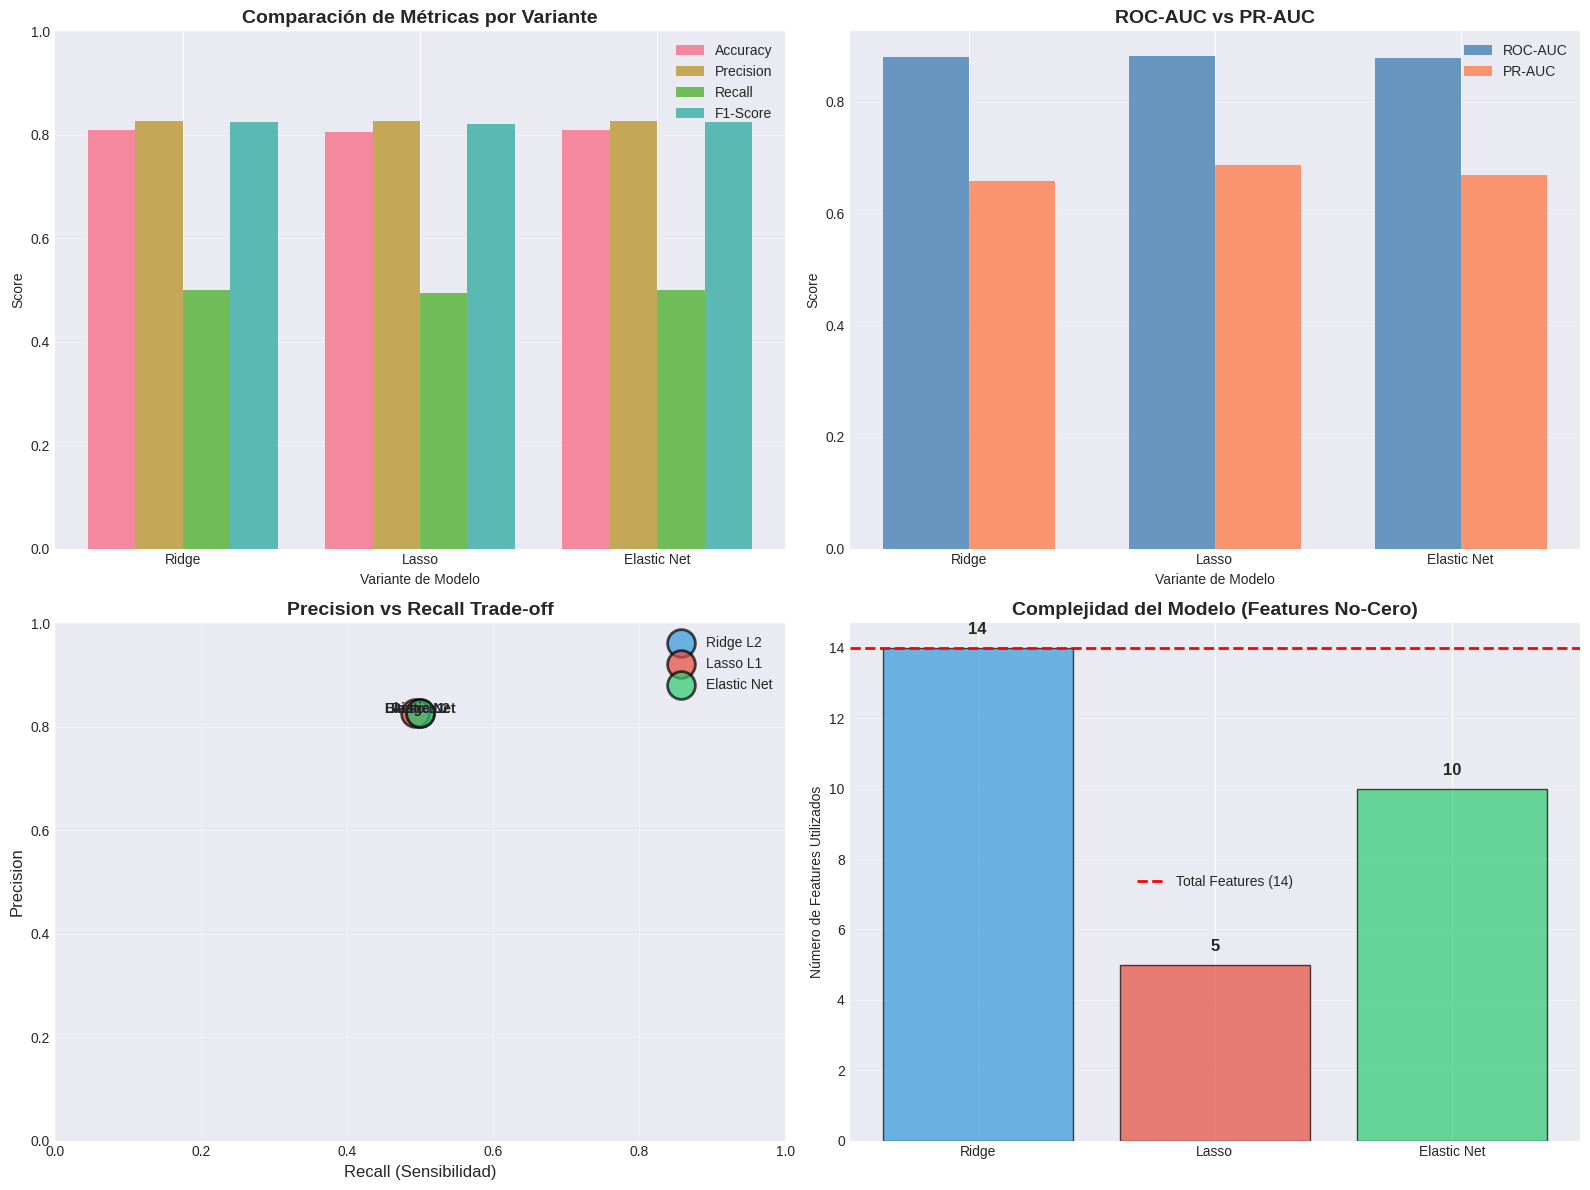

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_cols):
    axes[0, 0].bar(x + i*width, results_df[metric], width,
                   label=metric, alpha=0.8)

axes[0, 0].set_xlabel('Variante de Modelo')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Comparación de Métricas por Variante', fontsize=14, fontweight='bold')
axes[0, 0].set_xticks(x + width * 1.5)
axes[0, 0].set_xticklabels(['Ridge', 'Lasso', 'Elastic Net'], rotation=0)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_ylim([0, 1])

x_pos = np.arange(len(results_df))
width = 0.35
axes[0, 1].bar(x_pos - width/2, results_df['ROC-AUC'], width,
              label='ROC-AUC', color='steelblue', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, results_df['PR-AUC'], width,
              label='PR-AUC', color='coral', alpha=0.8)
axes[0, 1].set_xlabel('Variante de Modelo')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('ROC-AUC vs PR-AUC', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['Ridge', 'Lasso', 'Elastic Net'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

colors = ['#3498db', '#e74c3c', '#2ecc71']
for idx, (_, row) in enumerate(results_df.iterrows()):
    axes[1, 0].scatter(row['Recall'], row['Precision'],
                      s=400, c=[colors[idx]], edgecolors='black',
                      linewidth=2, alpha=0.7, label=row['Model'].split('(')[1].strip(')'))
    axes[1, 0].annotate(row['Model'].split('(')[1].strip(')'),
                       (row['Recall'], row['Precision']),
                       fontsize=10, ha='center', fontweight='bold')

axes[1, 0].set_xlabel('Recall (Sensibilidad)', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Precision vs Recall Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 1])
axes[1, 0].set_ylim([0, 1])
axes[1, 0].legend()

models_list = [lr_ridge_model, lr_lasso_model, lr_elastic_model]
feature_counts = [np.count_nonzero(m.coefficients.toArray()) for m in models_list]
colors_features = ['#3498db', '#e74c3c', '#2ecc71']

bars = axes[1, 1].bar(['Ridge', 'Lasso', 'Elastic Net'], feature_counts,
                     color=colors_features, edgecolor='black', alpha=0.7)
axes[1, 1].axhline(y=len(feature_cols), color='red', linestyle='--',
                   linewidth=2, label=f'Total Features ({len(feature_cols)})')
axes[1, 1].set_ylabel('Número de Features Utilizados')
axes[1, 1].set_title('Complejidad del Modelo (Features No-Cero)',
                     fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, feature_counts):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, height + 0.3,
                   f'{int(count)}', ha='center', va='bottom',
                   fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

### Coeficientes

In [ ]:
coef_comparison = pd.DataFrame({
    'Feature': feature_cols,
    'Ridge_Coef': lr_ridge_model.coefficients.toArray(),
    'Lasso_Coef': lr_lasso_model.coefficients.toArray(),
    'ElasticNet_Coef': lr_elastic_model.coefficients.toArray()
})

coef_comparison['Ridge_Abs'] = np.abs(coef_comparison['Ridge_Coef'])
coef_comparison['Lasso_Abs'] = np.abs(coef_comparison['Lasso_Coef'])
coef_comparison['ElasticNet_Abs'] = np.abs(coef_comparison['ElasticNet_Coef'])

coef_comparison['Mean_Abs'] = coef_comparison[['Ridge_Abs', 'Lasso_Abs', 'ElasticNet_Abs']].mean(axis=1)
coef_comparison = coef_comparison.sort_values('Mean_Abs', ascending=False)

print("\n Top 10 Features más importantes (promedio de variantes):\n")
print(coef_comparison[['Feature', 'Ridge_Coef', 'Lasso_Coef', 'ElasticNet_Coef']].head(10).to_string(index=False))


 Top 10 Features más importantes (promedio de variantes):

                 Feature  Ridge_Coef  Lasso_Coef  ElasticNet_Coef
               Num_Sites    1.557053    1.976890         1.869305
                   Years    0.516877    0.829190         0.599226
Age_Purchase_Interaction    0.418851    0.196164         0.292149
       Purchase_Per_Site   -0.536959    0.000000        -0.095220
                     Age    0.187085    0.232977         0.211239
           Years_Squared    0.296818    0.000000         0.207292
       Purchase_Per_Year   -0.316312    0.000000        -0.043172
          Total_Purchase    0.297138    0.000000         0.000000
           Onboard_Month    0.084176    0.082082         0.079023
          Sites_Per_Year    0.210273    0.000000         0.000000


### Visualización de coeficientes

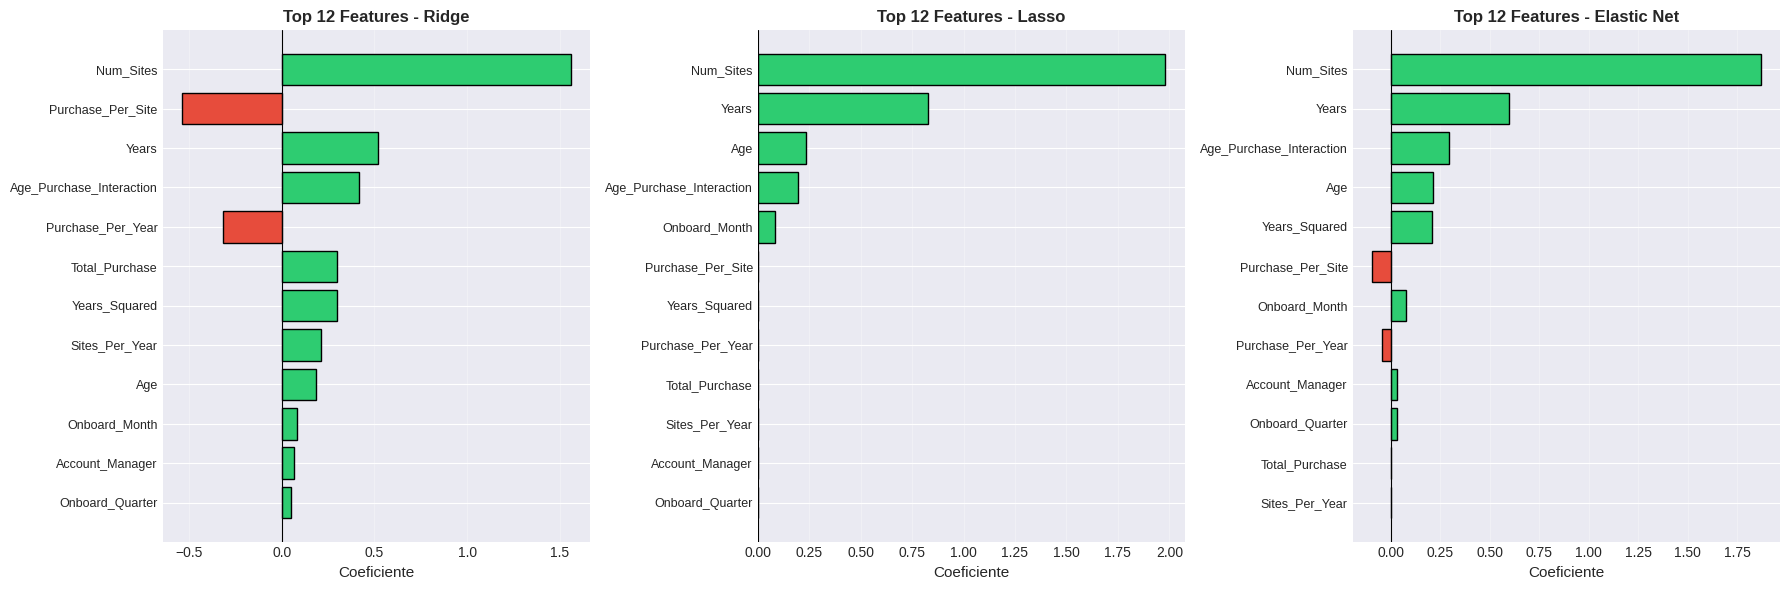

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

top_n = 12
for idx, (model_name, coef_col) in enumerate([('Ridge', 'Ridge_Coef'),
                                               ('Lasso', 'Lasso_Coef'),
                                               ('Elastic Net', 'ElasticNet_Coef')]):
    abs_col = f'{model_name.split()[0]}_Abs' if 'Elastic Net' not in model_name else 'ElasticNet_Abs'
    top_features = coef_comparison.nlargest(top_n, abs_col)
    colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in top_features[coef_col]]

    axes[idx].barh(range(top_n), top_features[coef_col].values,
                  color=colors, edgecolor='black')
    axes[idx].set_yticks(range(top_n))
    axes[idx].set_yticklabels(top_features['Feature'].values, fontsize=9)
    axes[idx].set_xlabel('Coeficiente', fontsize=11)
    axes[idx].set_title(f'Top {top_n} Features - {model_name}',
                       fontsize=12, fontweight='bold')
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[idx].grid(True, alpha=0.3, axis='x')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

### Feature Selection

In [ ]:
lasso_selected = coef_comparison[coef_comparison['Lasso_Coef'] != 0].copy()
lasso_eliminated = coef_comparison[coef_comparison['Lasso_Coef'] == 0].copy()

print(f"\n Features seleccionados por Lasso: {len(lasso_selected)}/{len(feature_cols)}")
print(f" Features eliminados por Lasso: {len(lasso_eliminated)}/{len(feature_cols)}")





 Features seleccionados por Lasso: 5/14
 Features eliminados por Lasso: 9/14


### Mejor Modelo

In [ ]:
print(f"Mejor Modelo: {best_name}")

Mejor Modelo: Logistic Regression (Ridge L2)


### Mátriz de Confusión para el mejor modelo

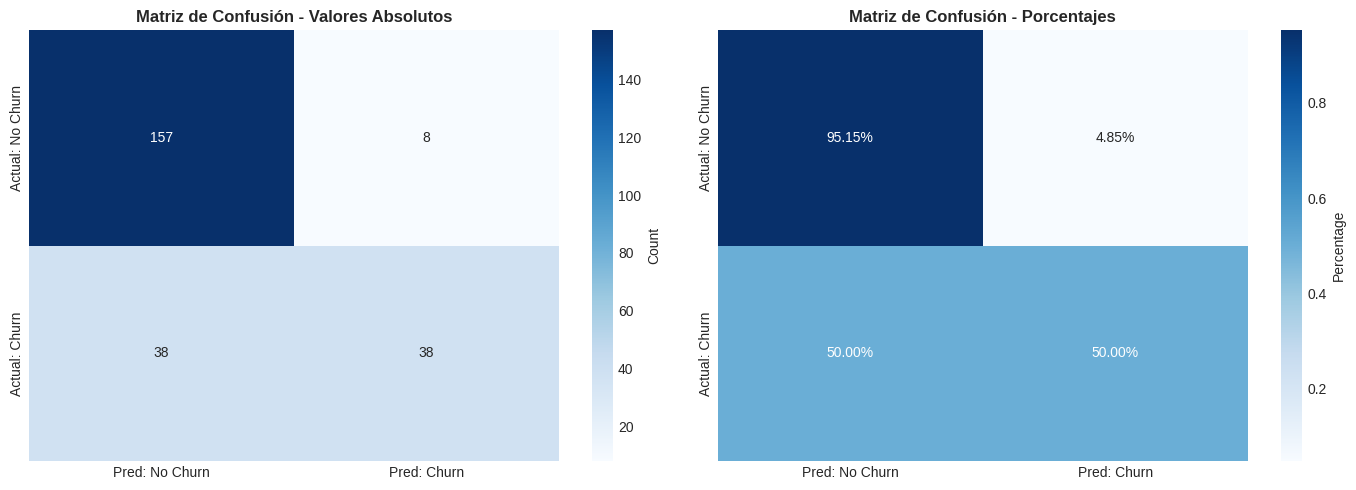

In [ ]:
best_results = all_results[best_idx]
cm = best_results['Confusion_Matrix']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_df = pd.DataFrame(cm,
                     index=['Actual: No Churn', 'Actual: Churn'],
                     columns=['Pred: No Churn', 'Pred: Churn'])
sns.heatmap(cm_df, annot=True, fmt='.0f', cmap='Blues', ax=axes[0],
           cbar_kws={'label': 'Count'})
axes[0].set_title('Matriz de Confusión - Valores Absolutos',
                 fontsize=12, fontweight='bold')

cm_percent = cm / cm.sum(axis=1)[:, np.newaxis]
cm_percent_df = pd.DataFrame(cm_percent,
                             index=['Actual: No Churn', 'Actual: Churn'],
                             columns=['Pred: No Churn', 'Pred: Churn'])
sns.heatmap(cm_percent_df, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
           cbar_kws={'label': 'Percentage'})
axes[1].set_title('Matriz de Confusión - Porcentajes',
                 fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
tn, fp = cm[0, 0], cm[0, 1]
fn, tp = cm[1, 0], cm[1, 1]

print(f"\n Métricas Detalladas del Mejor Modelo:")
print(f"   • True Negatives (TN): {int(tn)}")
print(f"   • False Positives (FP): {int(fp)}")
print(f"   • False Negatives (FN): {int(fn)}")
print(f"   • True Positives (TP): {int(tp)}")
print(f"   • Specificity: {(tn/(tn+fp)):.4f}")
print(f"   • Sensitivity/Recall: {(tp/(tp+fn)):.4f}")
print(f"   • Precision: {(tp/(tp+fp) if (tp+fp) > 0 else 0):.4f}")


 Métricas Detalladas del Mejor Modelo:
   • True Negatives (TN): 157
   • False Positives (FP): 8
   • False Negatives (FN): 38
   • True Positives (TP): 38
   • Specificity: 0.9515
   • Sensitivity/Recall: 0.5000
   • Precision: 0.8261


### Interpretación de Coeficientes

In [ ]:
best_model = models_list[best_idx]
best_coefs = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': best_model.coefficients.toArray(),
    'Odds_Ratio': np.exp(best_model.coefficients.toArray())
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n Interpretación de impacto en Churn (Top 8):\n")
for _, row in best_coefs.head(8).iterrows():
    if row['Coefficient'] > 0:
        direction = "AUMENTA"
    else:
        direction = "DISMINUYE"

    odds_change = (row['Odds_Ratio'] - 1) * 100
    print(f" {row['Feature']}:")
    print(f"   Coeficiente: {row['Coefficient']:.4f}")
    print(f"   Impacto: {direction} probabilidad de churn")
    print(f"   Odds Ratio: {row['Odds_Ratio']:.4f} ({odds_change:+.1f}% cambio en odds)")
    print()



 Interpretación de impacto en Churn (Top 8):

 Num_Sites:
   Coeficiente: 1.5571
   Impacto: AUMENTA probabilidad de churn
   Odds Ratio: 4.7448 (+374.5% cambio en odds)

 Purchase_Per_Site:
   Coeficiente: -0.5370
   Impacto: DISMINUYE probabilidad de churn
   Odds Ratio: 0.5845 (-41.5% cambio en odds)

 Years:
   Coeficiente: 0.5169
   Impacto: AUMENTA probabilidad de churn
   Odds Ratio: 1.6768 (+67.7% cambio en odds)

 Age_Purchase_Interaction:
   Coeficiente: 0.4189
   Impacto: AUMENTA probabilidad de churn
   Odds Ratio: 1.5202 (+52.0% cambio en odds)

 Purchase_Per_Year:
   Coeficiente: -0.3163
   Impacto: DISMINUYE probabilidad de churn
   Odds Ratio: 0.7288 (-27.1% cambio en odds)

 Total_Purchase:
   Coeficiente: 0.2971
   Impacto: AUMENTA probabilidad de churn
   Odds Ratio: 1.3460 (+34.6% cambio en odds)

 Years_Squared:
   Coeficiente: 0.2968
   Impacto: AUMENTA probabilidad de churn
   Odds Ratio: 1.3456 (+34.6% cambio en odds)

 Sites_Per_Year:
   Coeficiente: 0.2103
  

### Optimización de código

Ajuste con ponderación de clases (sin oversampling)

In [ ]:

counts = df_train_transformed.groupBy("Churn").count().collect()
total = df_train_transformed.count()
freq = {int(r["Churn"]): r["count"] for r in counts}
class_weights = {k: total / (2 * v) for k, v in freq.items()}

df_train_weighted = df_train_transformed.withColumn(
    "classWeight",
    F.when(F.col("Churn") == 0, F.lit(float(class_weights[0])))
     .otherwise(F.lit(float(class_weights[1])))
)


### Modelo optimizado

In [ ]:
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Churn",
    weightCol="classWeight",
    family="binomial",
    standardization=False,
    maxIter=200
)

paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.001, 0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])  # Ridge, ElasticNet, Lasso
    .build()
)

evaluator = BinaryClassificationEvaluator(
    labelCol="Churn",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

tvs = TrainValidationSplit(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8,
    seed=42
)

In [ ]:
print("\nEntrenando modelo optimizado con búsqueda de hiperparámetros...")
tvs_model = tvs.fit(df_train_weighted)
best_model = tvs_model.bestModel

print(f"Mejor combinación:")
print(f"   • regParam = {best_model._java_obj.getRegParam()}")
print(f"   • elasticNetParam = {best_model._java_obj.getElasticNetParam()}")



Entrenando modelo optimizado con búsqueda de hiperparámetros...
Mejor combinación:
   • regParam = 0.1
   • elasticNetParam = 0.0


### Evaluación

In [ ]:
pred_opt = best_model.transform(df_test_transformed)

auc_opt = evaluator.evaluate(pred_opt)
f1_eval = MulticlassClassificationEvaluator(
    labelCol="Churn", predictionCol="prediction", metricName="f1"
).evaluate(pred_opt)
acc_eval = MulticlassClassificationEvaluator(
    labelCol="Churn", predictionCol="prediction", metricName="accuracy"
).evaluate(pred_opt)

print(f"\nMétricas del modelo optimizado:")
print(f"   • AUC: {auc_opt:.4f}")
print(f"   • F1: {f1_eval:.4f}")
print(f"   • Accuracy: {acc_eval:.4f}")



Métricas del modelo optimizado:
   • AUC: 0.8749
   • F1: 0.8287
   • Accuracy: 0.8133


In [ ]:
print(pred_opt.columns)


['Age', 'Total_Purchase', 'Account_Manager', 'Years', 'Num_Sites', 'Purchase_Per_Year', 'Purchase_Per_Site', 'Sites_Per_Year', 'Days_Since_Onboard', 'Onboard_Year', 'Onboard_Month', 'Onboard_Quarter', 'Years_Squared', 'Age_Purchase_Interaction', 'Churn', 'features_raw', 'features', 'rawPrediction', 'probability', 'prediction']


In [ ]:
pred_prob = pred_opt.withColumn("prob_array", vector_to_array("probability")) \
                    .select("Churn", F.col("prob_array")[1].alias("p1"))

# Calcular métricas para distintos umbrales
thresholds = [x / 10 for x in range(1, 10)]
metrics = []
for t in thresholds:
    preds = pred_prob.withColumn("prediction", F.when(F.col("p1") >= t, 1.0).otherwise(0.0))
    acc = MulticlassClassificationEvaluator(
        labelCol="Churn", predictionCol="prediction", metricName="accuracy"
    ).evaluate(preds)
    f1 = MulticlassClassificationEvaluator(
        labelCol="Churn", predictionCol="prediction", metricName="f1"
    ).evaluate(preds)
    metrics.append((t, acc, f1))

metrics_df = spark.createDataFrame(metrics, ["Threshold", "Accuracy", "F1"])
metrics_pd = metrics_df.toPandas()

best_threshold = metrics_pd.loc[metrics_pd["F1"].idxmax(), "Threshold"]
best_f1 = metrics_pd["F1"].max()
print(f"\nUmbral óptimo según F1: {best_threshold:.2f} (F1={best_f1:.4f})")


Umbral óptimo según F1: 0.70 (F1=0.8572)


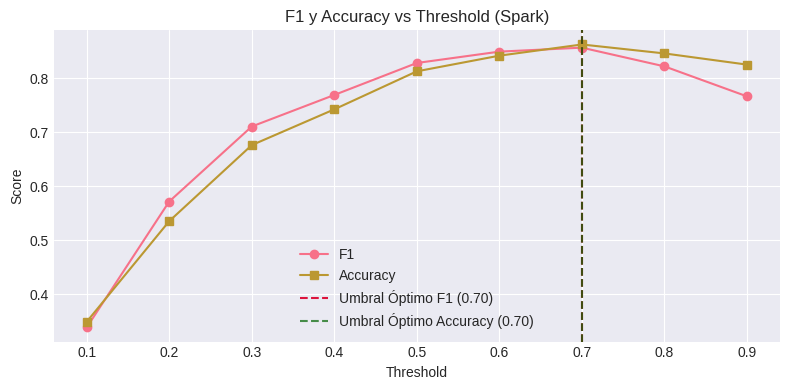

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(metrics_pd["Threshold"], metrics_pd["F1"], marker='o', label="F1")
plt.plot(metrics_pd["Threshold"], metrics_pd["Accuracy"], marker='s', label="Accuracy")
best_threshold_acc = metrics_pd.loc[metrics_pd["Accuracy"].idxmax(), "Threshold"]

plt.axvline(best_threshold, color='crimson', linestyle='--',
             label=f'Umbral Óptimo F1 ({best_threshold:.2f})')
plt.axvline(best_threshold_acc, color='darkgreen', linestyle='--',
             label=f'Umbral Óptimo Accuracy ({best_threshold_acc:.2f})', alpha=0.7)
plt.title('F1 y Accuracy vs Threshold (Spark)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

### Predicciones finales y comparativas

#### Predicciones con Mejor Modelo Base



In [ ]:
pred_ridge = lr_ridge_model.transform(df_nuevos_transformed)
pred_ridge = pred_ridge.withColumn("prob_array", vector_to_array("probability")) \
 .select("Names", "Company", F.col("prob_array")[1].alias("Prob_Churn_Ridge"))

#### Predicciones con Mejor Modelo Optimizado


In [ ]:
pred_opt_new = tvs_model.bestModel.transform(df_nuevos_transformed)

pred_opt_new = pred_opt_new.withColumn("prob_array", vector_to_array("probability")) \
                           .select("Names", "Company",
                                   F.col("prob_array")[1].alias("Prob_Churn_Opt"))

# Aplicar umbral de decisión 0.70 (óptimo F1)
pred_final = pred_opt_new.join(pred_ridge, on=["Names", "Company"], how="inner") \
                         .withColumn("Pred_Ridge", F.when(F.col("Prob_Churn_Ridge") >= 0.5, 1).otherwise(0)) \
                         .withColumn("Pred_Opt", F.when(F.col("Prob_Churn_Opt") >= 0.70, 1).otherwise(0))


In [ ]:
final_pd = pred_final.toPandas()
final_pd["Δ_Prob"] = (final_pd["Prob_Churn_Opt"] - final_pd["Prob_Churn_Ridge"]).round(4)

print("\nComparación de predicciones (Ridge vs Optimizado):")
display(final_pd[["Names", "Company",
                  "Prob_Churn_Ridge", "Prob_Churn_Opt",
                  "Δ_Prob", "Pred_Ridge", "Pred_Opt"]])


Comparación de predicciones (Ridge vs Optimizado):


,Names,Company,Prob_Churn_Ridge,Prob_Churn_Opt,Δ_Prob,Pred_Ridge,Pred_Opt
0,Andrew Mccall,King Ltd,0.417041,0.496353,0.0793,0,0
1,Michele Wright,Cannon-Benson,0.999160,0.986589,-0.0126,1,1
2,Jeremy Chang,Barron-Robertson,0.998395,0.991570,-0.0068,1,1
3,Megan Ferguson,Sexton-Golden,0.998668,0.983750,-0.0149,1,1
4,Taylor Young,Wood LLC,0.753001,0.711307,-0.0417,1,1
5,Jessica Drake,Parks-Robbins,0.890059,0.732787,-0.1573,1,1


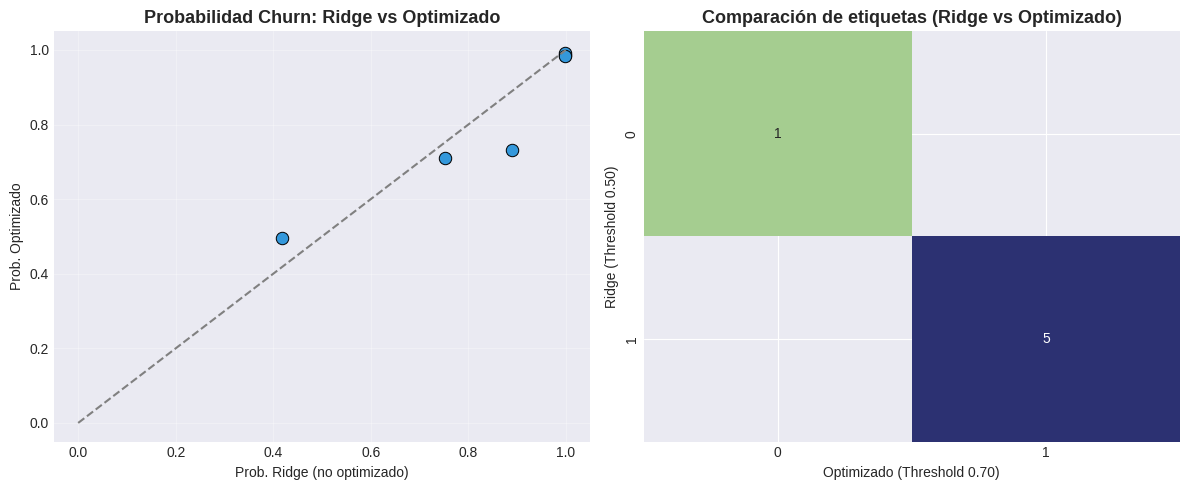

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribución de probabilidades
sns.scatterplot(data=final_pd, x="Prob_Churn_Ridge", y="Prob_Churn_Opt",
                s=80, color="#3498db", edgecolor="black", ax=axes[0])
axes[0].plot([0,1],[0,1],'--',color='gray')
axes[0].set_title("Probabilidad Churn: Ridge vs Optimizado", fontsize=13, fontweight='bold')
axes[0].set_xlabel("Prob. Ridge (no optimizado)")
axes[0].set_ylabel("Prob. Optimizado")
axes[0].grid(True, alpha=0.3)

# Comparación de predicciones (conteo)
pred_counts = (
    pred_final.groupBy("Pred_Ridge", "Pred_Opt").count().orderBy("Pred_Ridge", "Pred_Opt")
    .toPandas()
)
sns.heatmap(pred_counts.pivot(index="Pred_Ridge", columns="Pred_Opt", values="count"),
            annot=True, fmt=".0f", cmap="crest", cbar=False, ax=axes[1])
axes[1].set_title("Comparación de etiquetas (Ridge vs Optimizado)", fontsize=13, fontweight='bold')
axes[1].set_xlabel("Optimizado (Threshold 0.70)")
axes[1].set_ylabel("Ridge (Threshold 0.50)")

plt.tight_layout()
plt.show()


### Predicciones Futuras

In [ ]:

T_USE = 0.70
UPLIFT_MIN = 0.05

# --- 1. Base de nuevos clientes ---
df_new_base = df_nuevos_spark.fillna({"Account_Manager": 0.0}) \
    .withColumn("Account_Manager", F.col("Account_Manager").cast("double"))

# --- 2. Crear columnas derivadas necesarias para el pipeline ---
df_new_base = (
    df_new_base
    .withColumn("Purchase_Per_Year",  F.col("Total_Purchase") / F.col("Years"))
    .withColumn("Purchase_Per_Site",  F.col("Total_Purchase") / F.col("Num_Sites"))
    .withColumn("Sites_Per_Year",     F.col("Num_Sites") / F.col("Years"))
    .withColumn("Years_Squared",      F.pow(F.col("Years"), 2))
    .withColumn("Age_Purchase_Interaction", F.col("Age") * F.col("Total_Purchase"))
    .withColumn("Onboard_Year",   F.lit(2020))   # valores típicos para features temporales
    .withColumn("Onboard_Month",  F.lit(6))
    .withColumn("Onboard_Quarter",F.lit(2))
    .withColumn("Days_Since_Onboard", F.lit(365*F.col("Years")))  # aprox coherente con variable original
)

# --- 3. Escenarios: actual vs asignado ---
df_new_am0 = df_new_base.withColumn("AM_scenario", F.lit("actual"))
df_new_am1 = df_new_base.withColumn("Account_Manager", F.lit(1.0)) \
                        .withColumn("AM_scenario", F.lit("asignado"))

# --- 4. Función de scoring (sin AM_scenario en pipeline) ---
def score(df_in):
    cols = [c for c in df_in.columns if c != "AM_scenario"]
    df_tr = pipeline_model.transform(df_in.select(*cols))
    df_sc = tvs_model.bestModel.transform(df_tr) \
        .withColumn("p1", vector_to_array("probability")[1])
    return df_sc

# --- 5. Ejecutar predicciones ---
sc0 = score(df_new_am0).select("Names", "Company", "p1").withColumnRenamed("p1", "Prob_Churn_actual")
sc1 = score(df_new_am1).select("Names", "Company", "p1").withColumnRenamed("p1", "Prob_Churn_asignado")

# --- 6. Comparación y recomendación ---
comp = sc0.join(sc1, ["Names", "Company"], "inner") \
    .withColumn("Uplift", F.col("Prob_Churn_actual") - F.col("Prob_Churn_asignado")) \
    .withColumn("Pred_actual",   F.when(F.col("Prob_Churn_actual")  >= T_USE, 1).otherwise(0)) \
    .withColumn("Pred_asignado", F.when(F.col("Prob_Churn_asignado")>= T_USE, 1).otherwise(0)) \
    .withColumn(
        "Recomendar_Gerente",
        F.when((F.col("Prob_Churn_actual") >= T_USE) & (F.col("Uplift") >= UPLIFT_MIN), F.lit("Sí"))
         .otherwise(F.lit("No"))
    ) \
    .orderBy(F.desc("Uplift"))

comp_pd = comp.toPandas()

print("\nPredicciones futuras (actual vs asignando gerente) y recomendación:")
display(comp_pd[[
    "Names","Company","Prob_Churn_actual","Prob_Churn_asignado","Uplift",
    "Pred_actual","Pred_asignado","Recomendar_Gerente"
]])



Predicciones futuras (actual vs asignando gerente) y recomendación:


,Names,Company,Prob_Churn_actual,Prob_Churn_asignado,Uplift,Pred_actual,Pred_asignado,Recomendar_Gerente
0,Andrew Mccall,King Ltd,0.473600,0.473600,0.000000,0,0,No
1,Michele Wright,Cannon-Benson,0.985562,0.985562,0.000000,1,1,No
2,Jeremy Chang,Barron-Robertson,0.989639,0.989639,0.000000,1,1,No
3,Taylor Young,Wood LLC,0.732076,0.732076,0.000000,1,1,No
4,Jessica Drake,Parks-Robbins,0.757656,0.757656,0.000000,1,1,No
5,Megan Ferguson,Sexton-Golden,0.980537,0.983383,-0.002846,1,1,No


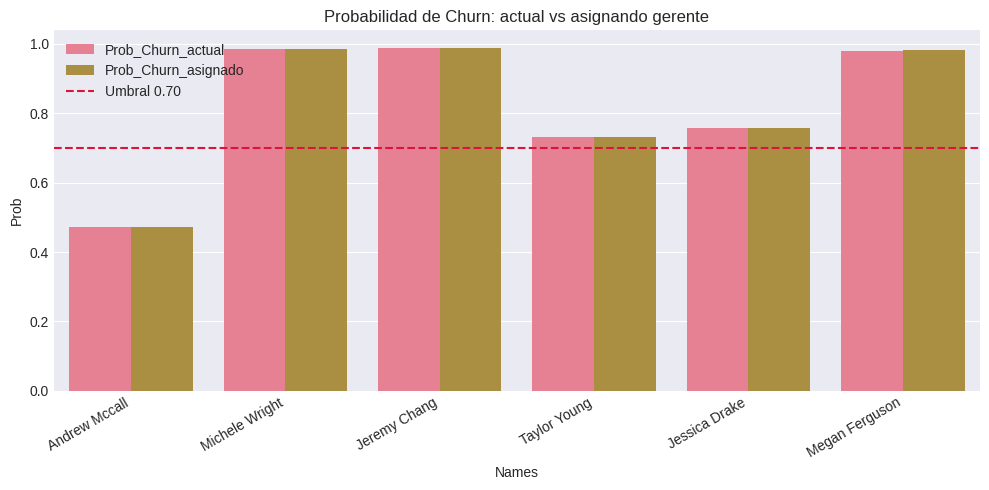

In [ ]:
plt.figure(figsize=(10,5))
melted = comp_pd.melt(id_vars=["Names"], value_vars=["Prob_Churn_actual","Prob_Churn_asignado"],
                      var_name="Escenario", value_name="Prob")
sns.barplot(data=melted, x="Names", y="Prob", hue="Escenario")
plt.axhline(T_USE, ls="--", color="crimson", label=f"Umbral {T_USE:.2f}")
plt.title("Probabilidad de Churn: actual vs asignando gerente")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()



### Peso de Account Manager en el Modelo

In [ ]:
stages = pipeline_model.stages
asm = [s for s in stages if s.__class__.__name__ == "VectorAssembler"][-1]
feat_names = asm.getInputCols()

coef = tvs_model.bestModel.coefficients.toArray()
intercept = tvs_model.bestModel.intercept

coef_df = pd.DataFrame({
    "feature": feat_names,
    "coef": coef,
    "odds_ratio": np.exp(coef)
}).sort_values("feature")

print("\nCoeficientes (exp(beta)=odds ratio):")
display(coef_df)

am_row = coef_df.loc[coef_df["feature"]=="Account_Manager"]
if len(am_row):
    beta = float(am_row["coef"].values[0])
    orv  = float(am_row["odds_ratio"].values[0])
    print(f"\nβ(Account_Manager) = {beta:.6f} | Odds Ratio = {orv:.6f}")
    if abs(beta) < 1e-3:
        print("Conclusión: el modelo considera que 'Account_Manager' no cambia materialmente la prob. de churn.")
else:
    print("\n'Account_Manager' no está en las columnas de entrada del assembler (revisar pipeline).")


Coeficientes (exp(beta)=odds ratio):


,feature,coef,odds_ratio
2,Account_Manager,0.080510,1.083839
0,Age,0.176472,1.193002
13,Age_Purchase_Interaction,0.219965,1.246033
8,Days_Since_Onboard,-0.004254,0.995755
4,Num_Sites,0.868566,2.383491
10,Onboard_Month,0.064979,1.067137
11,Onboard_Quarter,0.059173,1.060959
9,Onboard_Year,-0.003700,0.996307
6,Purchase_Per_Site,-0.331490,0.717853
5,Purchase_Per_Year,-0.128522,0.879394



β(Account_Manager) = 0.080510 | Odds Ratio = 1.083839
